In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/sample_submission.csv
/kaggle/input/dataset/test_identity.csv
/kaggle/input/dataset/train_identity.csv
/kaggle/input/dataset/test_transaction.csv
/kaggle/input/dataset/train_transaction.csv


In [3]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.4.1.post1 imbalanced-learn category_encoders

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.2 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [5]:
!pip install imblearn
!pip install mlflow
!pip install optbinning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import shap
import mlflow
import mlflow.sklearn

from optbinning import OptimalBinning
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 40.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 56.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [6]:
transaction_df = pd.read_csv("/kaggle/input/dataset/train_transaction.csv")
identity_df = pd.read_csv("/kaggle/input/dataset/train_identity.csv")
df = transaction_df.merge(identity_df, on="TransactionID", how="left")

# Feature Cleaning/Engineering

In [7]:
missing_ratio = df.isnull().mean()
df = df.drop(columns=missing_ratio[missing_ratio > 0.9].index)

In [9]:
target = "isFraud"

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])

In [11]:
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

In [12]:
# Categoricals: WoE on >3 ,  OHE on  <= 3
cat_features = X_train.select_dtypes(include="object").nunique()
ohe_features = cat_features[cat_features <= 3].index.tolist()
woe_features = cat_features[cat_features > 3].index.tolist()

In [13]:
# WoE encoding
woe_maps = {}
for col in woe_features:
    grouped = X_train[[col]].copy()
    grouped[target] = y_train.values
    woe_table = grouped.groupby(col)[target].agg(['count', 'sum'])
    woe_table['non_event'] = woe_table['count'] - woe_table['sum']
    woe_table['event_dist'] = woe_table['sum'] / woe_table['sum'].sum()
    woe_table['non_event_dist'] = woe_table['non_event'] / woe_table['non_event'].sum()
    woe_table['woe'] = np.log((woe_table['event_dist'] + 1e-6) / (woe_table['non_event_dist'] + 1e-6))
    woe_maps[col] = woe_table['woe'].to_dict()

for col in woe_features:
    X_train[col] = X_train[col].map(woe_maps[col])
    X_test[col] = X_test[col].map(woe_maps[col])

In [14]:
# Fill nulls using median for numeric columns
for col in X_train.columns:
    if X_train[col].dtype in [np.float64, np.int64]:
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)
    else:
        X_train[col] = X_train[col].fillna("missing")
        X_test[col] = X_test[col].fillna("missing")


In [15]:
# Apply OHE and Scaling
num_features = X_train.select_dtypes(include=np.number).columns.tolist()
num_features = [f for f in num_features if f not in ohe_features]

preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore"), ohe_features),
    ("scale", StandardScaler(), num_features)
])

In [18]:
# SHAP analysis with simple Logistic Regression to select top 95% important features
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])
pipe.fit(X_train, y_train)

explainer = shap.Explainer(pipe.named_steps["model"], pipe.named_steps["preprocess"].transform(X_train))
shap_values = explainer(pipe.named_steps["preprocess"].transform(X_train))

## Feature Importance

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class AutoSHAPFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, model_class, model_params=None, threshold=0.95):
        self.model_class = model_class
        self.model_params = model_params if model_params is not None else {}
        self.threshold = threshold
        self.selected_features_idx = None

    def fit(self, X, y):
        # Train a lightweight model internally
        model = self.model_class(**self.model_params)
        model.fit(X, y)

        # Compute SHAP values
        import shap
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        # Calculate mean absolute SHAP values
        importance = np.abs(shap_values.values).mean(0)
        importance_df = pd.DataFrame({
            "feature_idx": np.arange(X.shape[1]),
            "importance": importance
        }).sort_values("importance", ascending=False)

        # Cumulative importance
        importance_df["cumulative"] = importance_df["importance"].cumsum() / importance_df["importance"].sum()

        # Select features
        self.selected_features_idx = importance_df[importance_df["cumulative"] <= self.threshold]["feature_idx"].tolist()
        return self

    def transform(self, X):
        return X[:, self.selected_features_idx]

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [input_features[idx] for idx in self.selected_features_idx]
        else:
            return None

## Final Pipeline And Predict

In [22]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

pipe = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=0.2, random_state=42)),
    ("preprocess", preprocessor),
    ("feature_select", AutoSHAPFeatureSelector(model_class=LogisticRegression, model_params={"max_iter": 1000}, threshold=0.95)),
    ("model", LogisticRegression(max_iter=1000))
])

In [23]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
                ('preprocess',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['M1', 'M2', 'M3', 'M4', 'M5',
                                                   'M6', 'M7', 'M8', 'M9',
                                                   'id_12', 'id_15', 'id_16',
                                                   'id_28', 'id_29', 'id_35',
                                                   'id_36', 'id_37', 'id_38',
                                                   'DeviceType']),
                                                 ('scale', StandardScaler(),
                                                  ['TransactionID...
                                                   'card5', 'card6', 'addr1',
                                                   'addr2', 'dist1',
                                                   'P_emaildomain',
                                                   'R_emaildomain', 'C1', 'C2',
                                                   'C3', 'C4', 'C5', 'C6', 'C7',
                                                   'C8', 'C9', 'C10', 'C11',
                                                   'C12', 'C13', 'C14', 'D1', ...])])),
                ('feature_select',
                 AutoSHAPFeatureSelector(model_class=<class 'sklearn.linear_model._logistic.LogisticRegression'>,
                                         model_params={'max_iter': 1000})),
                ('model', LogisticRegression(max_iter=1000))])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.47      0.47      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.72      0.72    118108
weighted avg       0.96      0.96      0.96    118108

Accuracy:  0.9627
Precision: 0.4666
Recall:    0.4667
F1 Score:  0.4667
AUC:       0.8723


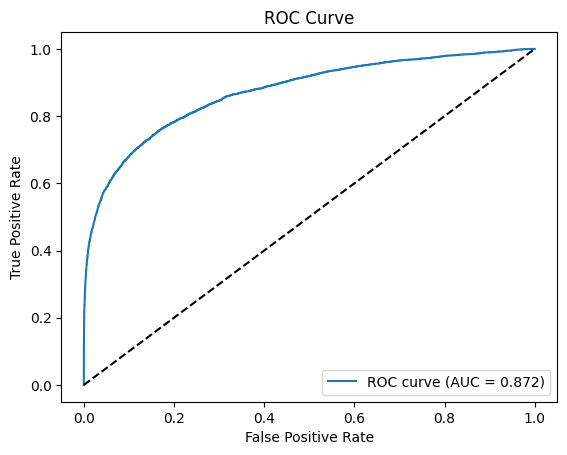

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

y_pred = pipe.predict(X_test)
y_score = pipe.predict_proba(X_test)[:,1]

# Classification report
print(classification_report(y_test, y_pred))

# Compute metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_score)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

## Mlflow logging

In [28]:
!pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 1.2 MB/s eta 0:00:00eta 0:00:01
  Attempting uninstall: graphql-core
    Found existing installation: graphql-core 3.2.6
    Uninstalling graphql-core-3.2.6:
      Successfully uninstalled graphql-core-3.2.6
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


In [29]:
import dagshub
dagshub.init(repo_owner='losaberidzebadri', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=d026efbd-0ff6-40fa-bcc1-30f4c1b4b9d1&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ebbc33e1f4cf3f2462348be37428acabac3f2657749a0e2b0aca5b5ec62a6111




Accessing as losaberidzebadri

Initialized MLflow to track repo "losaberidzebadri/IEEE-CIS-Fraud-Detection"

Repository losaberidzebadri/IEEE-CIS-Fraud-Detection initialized!

In [30]:
import mlflow
import mlflow.sklearn

# Start MLflow run
with mlflow.start_run(run_name="LogisticRegression_CleanV2"):
    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", auc)
    # Log ROC plot
    mlflow.log_artifact("roc_curve.png")
    # Log the trained model
    mlflow.sklearn.log_model(pipe, "logistic_model")

2025/04/26 21:12:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_CleanV2 at: https://dagshub.com/losaberidzebadri/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0/runs/07e9fc94a8e94af3a776e243dbd3f6ad
🧪 View experiment at: https://dagshub.com/losaberidzebadri/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/0
